# YamboCalculation: a simple G0W0 run

This is the calcjob class of the plugin that runs a single yambo calculation (p2y+yambo), and does not involve any outputs analysis or further post processing (like calculation of gaps, excitonic eigenvalues and so on).

The idea is to create a builder instance, which collects all the inputs needed for the simulation, then submit it by means of the aiida "submit" function.

In [6]:
from aiida import load_profile, orm
load_profile()

from aiida import orm

## 0 - A quantumespresso parent calculation

Before to run any yambo simulation, you need to have a quantumespresso nscf simulation. This can be done following the aiida-quantumespresso tutorial (contained in the AiiDA tutorials), or using one of the examples provided in the aiida-yambo plugin package (examples/plugin/...).

## 1 - Creation of YamboCalculation and builder instances

In [7]:
from aiida.plugins import CalculationFactory

In [8]:
YamboCalculation = CalculationFactory('yambo.yambo')

In [9]:
builder = YamboCalculation.get_builder()

## 2 - Setting up inputs
If you now inspect the builder methods, by using the tab, you can see that there are several inputs that you need to provide: code, metadata, parameters...

In [10]:
builder. #tab completion

SyntaxError: invalid syntax (2022531530.py, line 1)

SyntaxError: invalid syntax (2022531530.py, line 1)

## 2.1 Codes
We must provide the codes (yambo and p2y):

In [11]:
builder.code = orm.load_code('yyambonicola@lyra2')               #yambo executable
builder.preprocessing_code = orm.load_code('p2y@lyra2')  #p2y   executable

## 2.2 Resources 
Then you should set up the options about resources and submission settings. 
These have to be stored as a python dictionary in the metadata method:

In [12]:
builder.metadata.options = {
    'max_wallclock_seconds': 60*60, # in seconds
    'resources': {
            "num_machines": 1, # nodes
            "num_mpiprocs_per_machine": 16, # MPI per nodes
            "num_cores_per_mpiproc": 1, # OPENMP
        },
    'prepend_text': u"export OMP_NUM_THREADS="+str(1), # if needed
    #'account':'project_name',
    'queue_name':'s3par',
    #'qos':'',
}

## 2.3 Yambo inputs
The yambo inputs, used to write the input file (yambo.in -> aiida.in) are provided as a python dictionary, then
store as an AiiDA Dict. 
Runlevels are included under the 'arguments' key, as a list of strings. Parameters are instead in the 'variables' dictionary, as you can see. The format is the same as yambopy (indeed, to write the input file, the code uses the YamboIn() function of yambopy).

In [13]:
params = {
        'arguments': [
            'dipoles',
            'HF_and_locXC',
            'dipoles',
            'gw0',
            'ppa',],
        'variables': {
            'Chimod': 'hartree',
            'DysSolver': 'n',
            'GTermKind': 'BG',
            'NGsBlkXp': [2, 'Ry'],
            'BndsRnXp': [[1, 50], ''],
            'GbndRnge': [[1, 50], ''],
            'QPkrange': [[[1, 10, 4, 5]], ''],}}

builder.parameters = orm.Dict(dict=params)

You can also provide a settings dictionary, where to specify some instructions (False is default for any of them)

In [14]:
builder.settings = orm.Dict(dict={
    'INITIALISE': False, # if True, run only p2y and yambo initialization
    'COPY_DBS': False,   # if True, copy the out folder of a previous yambo calculation
    'COPY_SAVE': False,  # if True, copy the SAVE folder of a previous yambo calculation
    'RESTART_YAMBO': False, # if True, soft-link the out folder of a previous yambo calculation
})


#To run  only p2y+yambo init, it is possible to set:
#params_gw = Dict(dict={
#        'arguments': [],
#        'variables': {}})


## 2.3.1 If want to run BSE on top of QP
we provide as input the pk of the QP SingleFileData and then we add the instruction in the BSE inputs:

    builder.QP_corrections = orm.load_node(11)    ---> QP_db node
    params['variables']['KfnQPdb'] =  "E < ./ndb.QP"
    builder.parameters = orm.Dict(dict=params)

## 2.4 Setting the parent nscf calculation

In [16]:
nscf_pk = 1762 # the pk of the nscf calculation.


builder.parent_folder = orm.load_node(nscf_pk).outputs.remote_folder

## 3 RUN

In [17]:
from aiida.engine import submit

In [18]:
run = None

In [19]:
if run:
    print('run is already running -> {}'.format(run.pk))
    print('sure that you want to run again?, if so, copy the else instruction in the cell below and run!')
else:
    run = submit(builder)

print(run)

uuid: 83e61750-a915-4a90-8e37-dae5a3ae4cd2 (pk: 1771) (aiida.calculations:yambo.yambo)
uuid: 83e61750-a915-4a90-8e37-dae5a3ae4cd2 (pk: 1771) (aiida.calculations:yambo.yambo)


# Inspecting the outputs

suppose that your calculation completed successfully, then you can access the outputs via the output method of the run instance: 

In [28]:
run.is_finished_ok

True

True

In [29]:
run.outputs. #+TAB

SyntaxError: invalid syntax (708973465.py, line 1)

SyntaxError: invalid syntax (708973465.py, line 1)

For example, we have the array_ndb ArrayData, which essentially contains the information on the run.output.QP_DB (which can also be accessed directly):

In [30]:
run.outputs.array_ndb.get_arraynames()

['E',
 'Z',
 'Eo',
 'Sc',
 'Sx',
 'Vxc',
 'Band',
 'Kpoint',
 'nbands',
 'nkpoints',
 'qp_table',
 'E_minus_Eo',
 'Kpoint_index']

['E',
 'Z',
 'Eo',
 'Sc',
 'Sx',
 'Vxc',
 'Band',
 'Kpoint',
 'nbands',
 'nkpoints',
 'qp_table',
 'E_minus_Eo',
 'Kpoint_index']

In [31]:
E_dft = run.outputs.array_ndb.get_array('Eo') #Ha
E_qp = run.outputs.array_ndb.get_array('E')   #Ha

In [32]:
from matplotlib import pyplot as plt

In [33]:
from ase import units

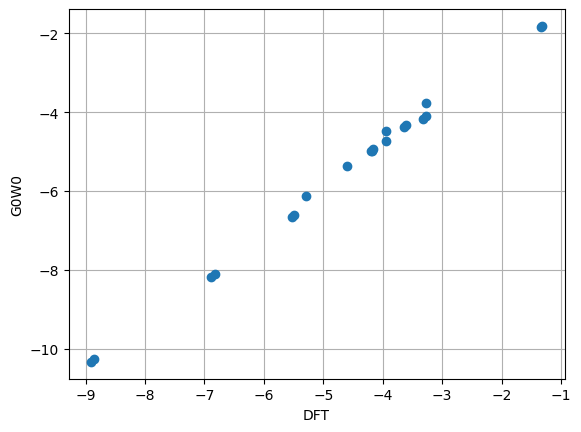

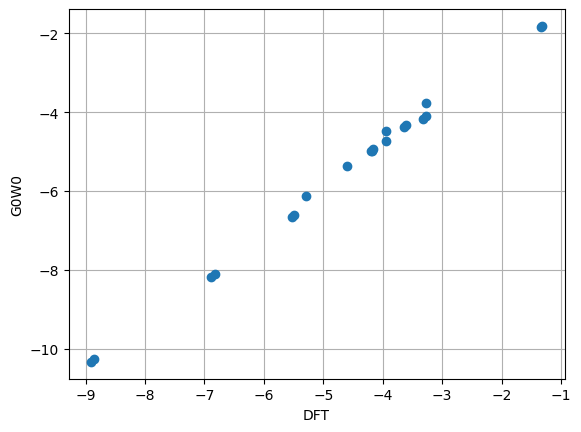

In [34]:
plt.plot(E_dft.real*units.Ha,E_qp.real*units.Ha,'o')
plt.ylabel('G0W0')
plt.xlabel('DFT')
plt.grid()

In [35]:
E_qp

array([-0.16462387+0.00077033j, -0.06772136+0.00045646j,
       -0.22510445+0.00060851j, -0.06651741+0.00045588j,
       -0.15294127+0.00051582j, -0.13818671+0.00056086j,
       -0.19697332+0.00065934j, -0.15032186+0.00051307j,
       -0.29776436+0.00065744j, -0.16032639+0.00052901j,
       -0.30045283+0.00063491j, -0.15843585+0.00052791j,
       -0.37745512+0.00075562j, -0.18304294+0.00054882j,
       -0.37981495+0.00075754j, -0.18107261+0.00054768j,
       -0.2432531 +0.00060163j, -0.182947  +0.00052153j,
       -0.24438497+0.00060466j, -0.17404953+0.00053314j], dtype=complex64)

array([-0.16462387+0.00077033j, -0.06772136+0.00045646j,
       -0.22510445+0.00060851j, -0.06651741+0.00045588j,
       -0.15294127+0.00051582j, -0.13818671+0.00056086j,
       -0.19697332+0.00065934j, -0.15032186+0.00051307j,
       -0.29776436+0.00065744j, -0.16032639+0.00052901j,
       -0.30045283+0.00063491j, -0.15843585+0.00052791j,
       -0.37745512+0.00075562j, -0.18304294+0.00054882j,
       -0.37981495+0.00075754j, -0.18107261+0.00054768j,
       -0.2432531 +0.00060163j, -0.182947  +0.00052153j,
       -0.24438497+0.00060466j, -0.17404953+0.00053314j], dtype=complex64)

In [39]:
run.outputs.output_parameters.get_dict()

{'errors': [],
 'timing': [' <---> P1: [01] MPI/OPENMP structure, Files & I/O Directories\n',
  ' <---> P1: [02] CORE Variables Setup\n',
  ' <---> P1: [03] Transferred momenta grid and indexing\n',
  ' <---> P1: [04] Dipoles\n',
  ' <02s> P1: [05] Dynamic Dielectric Matrix (PPA)\n',
  ' <06s> P1: [06] Local Exchange-Correlation + Non-Local Fock\n',
  ' <07s> P1: [07] Dyson equation: Newton solver\n',
  ' <08s> P1: [08] Timing Overview\n',
  ' <08s> P1: [09] Memory Overview\n',
  ' <08s> P1: [10] Game Over & Game summary\n'],
 'has_gpu': False,
 'memstats': [],
 'warnings': [],
 'Fermi(eV)': 5.025779,
 'game_over': True,
 'last_time': 8,
 'para_error': False,
 'time_error': False,
 'ns_db1_path': '/tmp/tmpuzl7_1gf',
 'memory_error': False,
 'p2y_completed': True,
 'yambo_version': '5.x',
 'requested_time': 3600,
 'last_time_units': 'seconds',
 'yambo_wrote_dbs': True,
 'corrupted_fragment': False,
 'X_par_allocation_error': False}

{'errors': [],
 'timing': [' <---> P1: [01] MPI/OPENMP structure, Files & I/O Directories\n',
  ' <---> P1: [02] CORE Variables Setup\n',
  ' <---> P1: [03] Transferred momenta grid and indexing\n',
  ' <---> P1: [04] Dipoles\n',
  ' <02s> P1: [05] Dynamic Dielectric Matrix (PPA)\n',
  ' <06s> P1: [06] Local Exchange-Correlation + Non-Local Fock\n',
  ' <07s> P1: [07] Dyson equation: Newton solver\n',
  ' <08s> P1: [08] Timing Overview\n',
  ' <08s> P1: [09] Memory Overview\n',
  ' <08s> P1: [10] Game Over & Game summary\n'],
 'has_gpu': False,
 'memstats': [],
 'warnings': [],
 'Fermi(eV)': 5.025779,
 'game_over': True,
 'last_time': 8,
 'para_error': False,
 'time_error': False,
 'ns_db1_path': '/tmp/tmpuzl7_1gf',
 'memory_error': False,
 'p2y_completed': True,
 'yambo_version': '5.x',
 'requested_time': 3600,
 'last_time_units': 'seconds',
 'yambo_wrote_dbs': True,
 'corrupted_fragment': False,
 'X_par_allocation_error': False}

In [37]:
run.outputs.QP_db

<SinglefileData: uuid: 31877854-f4a1-46ff-aa55-133371702934 (pk: 1774)>

<SinglefileData: uuid: 31877854-f4a1-46ff-aa55-133371702934 (pk: 1774)>